# Softmax

Celem softmax jest przerobienie liczb rzeczywistych $r_0,\ldots,r_{n-1}$ na prawdopodobieństwa $p_0,\ldots,p_{n-1}$

W tym celu wykonuje się dwa kroki:
* najpierw się robi dodatnie
$$
s_i =\exp(r_i)
$$
* następnie się normalizuje
$$
p_i=\frac{s_i}{\sum_j s_j}=\frac{\exp(r_i)}{\sum_j \exp(r_j)}.
$$

Aby to liczyć stabilnie numerycznie, dodatkowo dzieli się górę i dół przez największą eksponentę z mianownika, czyli finalnie
$$
p_i=\frac{\exp(r_i-\max r)}{\sum_j \exp(r_j-\max r)}
$$

Odwzorowanie $(r_i) \to (p_i)$ nazywa się *softmax*.

Zwyczajowo wartości $r_i$ nazywa się *logitami*.


In [1]:
import numpy as np

def softmax(x):
    e_x = np.exp(x - np.max(x))  # stabilizacja numeryczna
    return e_x / np.sum(e_x)

In [8]:
# przykład użycia

logits = np.array([2.0, 1.0, 0.1])
probabilities = softmax(logits)
print(probabilities)
print(np.sum(probabilities))

# możmy uzyskac numeryczne zero dla odpowiednio dużych wartości
logits = np.array([10.0**100, 1.0, 0.1])
probabilities = softmax(logits)
print(probabilities)
print(np.sum(probabilities))


[0.65900114 0.24243297 0.09856589]
1.0
[1. 0. 0.]
1.0


# CE loss

Jeżeli w modelu klasyfikacyjnym użyjemy funkcji softmax, i będziemy chcieli maksymalizować log-likelihood prawidłowej klasy, to dostajemy równoważnie minimalizację Cross-Entropy loss (CE loss).

Aby użyć, stosujemy one-hot encoding, czyli klasę o indeksie $i$ reprezentujemy przez wektor mający $1$ na $i$-tej wspołrzędnej i zero poza nim.



In [5]:
# definiujemy one-hot encoding dla klasy k, gdy mamy sumarycznie n klas
def onehot(k,n):
  return np.array([1 if i==k else 0 for i in range(n)])

onehot(2,5)

array([0, 0, 1, 0, 0])

Finalnie, jeżeli punkt $x$ ma klasę $y$ (zapisaną w postaci one-hot), a model przewidział rozkład prawdopoodbieństwa $\tilde y$, to logarytm prawdopodobieństwa wylosowania prawdidłowej klasy wynosi (czyli log-lieklihood)
$$
\sum_i y_i \log \tilde y_i.
$$

Finalnie w sieciach dokonujemy minimalizacji, więc
$$
CE(y, \tilde y)=-\sum_i y_i \log \tilde y_i.
$$



In [6]:
import numpy as np

y_true = [1, 0, 0]  # prawdziwa klasa: 0
y_pred = [0.7, 0.2, 0.1]  # wynik softmaxu modelu

loss = -np.sum(np.array(y_true) * np.log(y_pred))
print(loss)  # ≈ 0.357

0.35667494393873245


# Stabilne liczenie CE loss

Załóżmy teraz, że mamy logity $r=(r_i)$, prawddziwą klasę $y$ i chcemy wyliczyć
$$
CE(y,\tilde y) \text{ dla } \tilde y=softmax(r).
$$
Zauważmy, że może się (a nawet zdarzy się), że $\tilde y$ będzie miało numeryczne zero w którymś indeksie, i dostaniemy niestabilność numeryczną.

Aby to wyliczyć stabilnie, korzysta się z następującego wzoru
$$
\log softmax(r)_i=\log (\exp(r_i))-\log(\sum_j \exp(r_j))=r_i-\log(\sum_j \exp(r_j))
$$

do stabilnego wyliczenia tej ostatniej funkcji możemy użyć albo wzoru
$$
\log (\sum_j \exp r_j)=\max r +\log (\sum_j \exp(r_j-\max r)),
$$
albo po prostu już gotowej funkcji logsumexp, i wtedy byśmy dostali
$$
CEloss(y,r)=logsumexp(r)-\sum_j y_j r_j.
$$

In [10]:
import numpy as np
from scipy.special import logsumexp

def cross_entropy_loss(y_true, logits):
    """
    Oblicza stabilną cross-entropy loss dla jednej próbki, gdy y_true jest wektorem one-hot.

    Parametry:
    y_true  -- wektor one-hot (np. [0, 1, 0] dla klasy 1)
    logits  -- surowe wyniki modelu (logity), przed softmaxem (tablica NumPy)

    Zwraca:
    Skalarną wartość cross-entropy loss.
    """
    return logsumexp(logits) - np.dot(y_true, logits)


# Regresja logistyczna -- Model sieci jednowarstwowej zbudowanej do klasyfikacji wieloklasowej

Nasza sieć:

## wejście → (macierz wag + bias) → softmax → cross-entropy loss

Finalnie można też łatwo wyliczyć dla regresji logistycznej gradienty lossu (dla wag i biasu).

# Finalny model z wizualizacją

Przedstawiam gotowy model korzystający z sieci w PyTorch

Epoch [100/1000], Loss: 0.4398
Epoch [200/1000], Loss: 0.3466
Epoch [300/1000], Loss: 0.3012
Epoch [400/1000], Loss: 0.2733
Epoch [500/1000], Loss: 0.2540
Epoch [600/1000], Loss: 0.2396
Epoch [700/1000], Loss: 0.2283
Epoch [800/1000], Loss: 0.2192
Epoch [900/1000], Loss: 0.2115
Epoch [1000/1000], Loss: 0.2050


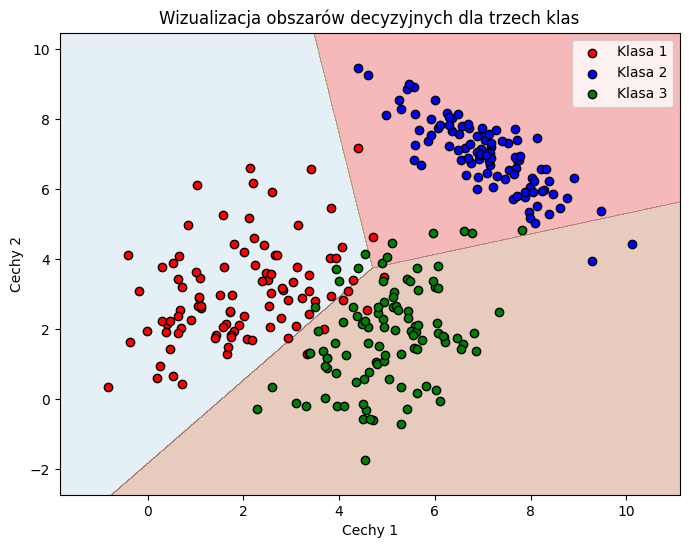

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import LabelBinarizer



# Model regresji logistycznej
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)  # Warstwa liniowa

    def forward(self, x):
        return self.fc(x)

"""
Wizualizacja na zbiorze składającym się z 3 gaussów
"""

# Parametry dla 3 klas
mean1 = [2, 3]
cov1 = [[2, 0.8], [0.8, 2]]  # macierz kowariancji
mean2 = [7, 7]
cov2 = [[1, -0.8], [-0.8, 1]]
mean3 = [5, 2]
cov3 = [[1, 0.5], [0.5, 2]]

# Generowanie próbek z trzech rozkładów normalnych (Gaussowskich)
class1 = np.random.multivariate_normal(mean1, cov1, 100)
class2 = np.random.multivariate_normal(mean2, cov2, 100)
class3 = np.random.multivariate_normal(mean3, cov3, 100)

# Łączenie próbek w jeden zbiór danych
X = np.vstack((class1, class2, class3))
y = np.array([0] * 100 + [1] * 100 + [2] * 100)  # Etykiety klas

# Przekształcamy dane na tensory
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

"""
trening modelu
"""


# Inicjalizacja modelu
model = LogisticRegression(input_dim=2, output_dim=3)  # 2 cechy wejściowe, 3 klasy

# Ustawienia optymalizatora i funkcji straty
criterion = nn.CrossEntropyLoss()  # Strata cross-entropy
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Trening modelu
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()

    # Forward pass
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)

    # Backward pass i optymalizacja
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Monitoring
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Wizualizacja obszarów decyzyjnych
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Konwersja siatki na tensor
grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

# Predykcja na siatce
model.eval()
with torch.no_grad():
    Z = model(grid_tensor)
    _, Z = torch.max(Z, 1)  # Zwraca indeksy klas

Z = Z.numpy().reshape(xx.shape)

# Tworzenie wykresu
plt.figure(figsize=(8, 6))

# Wizualizacja obszarów decyzyjnych
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.3)

# Wizualizacja danych
plt.scatter(class1[:, 0], class1[:, 1], color='red', label='Klasa 1', edgecolors='k')
plt.scatter(class2[:, 0], class2[:, 1], color='blue', label='Klasa 2', edgecolors='k')
plt.scatter(class3[:, 0], class3[:, 1], color='green', label='Klasa 3', edgecolors='k')

# Etykiety i legenda
plt.title('Wizualizacja obszarów decyzyjnych dla trzech klas')
plt.xlabel('Cechy 1')
plt.ylabel('Cechy 2')
plt.legend()

# Wyświetlenie wykresu
plt.show()


## Zadanie
Proszę napisać model optymalizacji dla regresji logistycznej korzystając jedynie z numpy (bez torch).

# Model MLP do klasyfikacji na zbiorze MNIST

sieć dwuwarstwowa.



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.27MB/s]


Epoch [1/10], Loss: 0.3755, Train Accuracy: 93.63%, Test Accuracy: 93.57%
Epoch [2/10], Loss: 0.1957, Train Accuracy: 95.78%, Test Accuracy: 95.45%
Epoch [3/10], Loss: 0.1437, Train Accuracy: 96.80%, Test Accuracy: 96.42%
Epoch [4/10], Loss: 0.1168, Train Accuracy: 97.27%, Test Accuracy: 96.72%
Epoch [5/10], Loss: 0.0970, Train Accuracy: 97.05%, Test Accuracy: 96.30%
Epoch [6/10], Loss: 0.0858, Train Accuracy: 97.85%, Test Accuracy: 97.04%
Epoch [7/10], Loss: 0.0765, Train Accuracy: 98.05%, Test Accuracy: 97.08%
Epoch [8/10], Loss: 0.0688, Train Accuracy: 98.16%, Test Accuracy: 96.97%
Epoch [9/10], Loss: 0.0625, Train Accuracy: 98.58%, Test Accuracy: 97.52%
Epoch [10/10], Loss: 0.0583, Train Accuracy: 98.61%, Test Accuracy: 97.52%


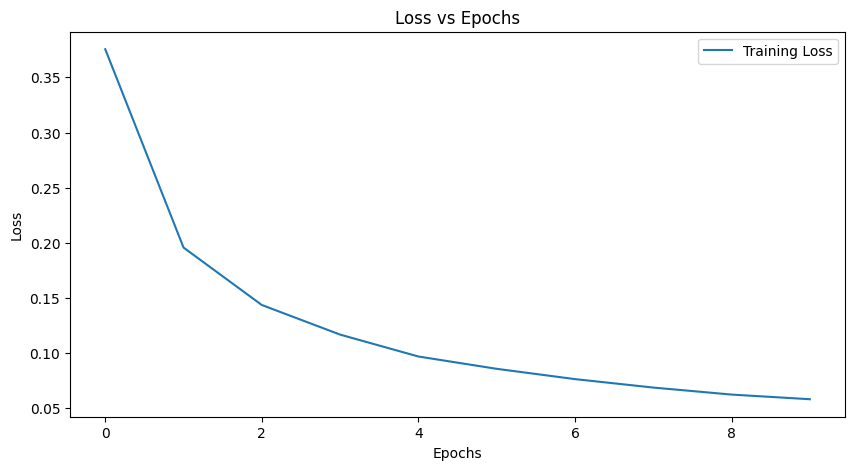

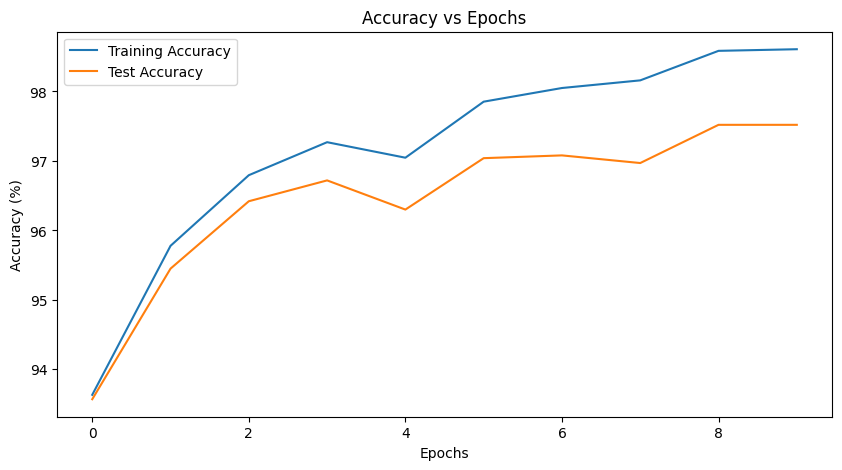

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Transformacja wejściowa: normalizacja obrazów z MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizacja z wartościami średnimi i odchyleniami standardowymi
])

# Załadowanie danych MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# batch size =64
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Warstwa ukryta
        self.fc2 = nn.Linear(hidden_size, output_size)  # Warstwa wyjściowa

    def forward(self, x):
        x = torch.flatten(x, 1)  # Spłaszczamy obrazy do jednego wymiaru
        x = torch.relu(self.fc1(x))  # Funkcja aktywacji ReLU
        x = self.fc2(x)  # Warstwa wyjściowa
        return x

# Parametry modelu
input_size = 28 * 28  # Rozmiar obrazu MNIST
hidden_size = 128  # Rozmiar warstwy ukrytej
output_size = 10  # Liczba klas (0-9)

# Inicjalizacja modelu
model = MLP(input_size, hidden_size, output_size)

# Ustawienie optymalizatora i funkcji straty
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Funkcja do obliczania dokładności
def calculate_accuracy(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Trenowanie modelu
num_epochs = 10
train_losses = []
test_accuracies = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Ustawienie modelu w tryb treningowy
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()  # Zerowanie gradientów
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Obliczanie straty
        loss.backward()  # Backward pass
        optimizer.step()  # Optymalizacja

        running_loss += loss.item()

    # Obliczanie dokładności na zbiorze treningowym i testowym
    train_acc = calculate_accuracy(train_loader)
    test_acc = calculate_accuracy(test_loader)

    # Zapisywanie wyników
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, '
          f'Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')

# Wykres strat
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

# Wykres dokładności
plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

